In [2]:
import glob
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

infos = pd.read_excel("../../1_NanoNASCseq/data/NanoNASCseq.xls")
runs = ["20220719_K562R1", "20220719_K562R2", "20220719_K562R3", "20220719_K562R4", "20220729_K562R1", "20220729_K562R2"]

# Profiling of dual-TSO

In [2]:
array = []
for run in runs:
    tmp = infos[infos["Run"] == run]
    m = np.zeros((6, 6), dtype=np.int)
    for cell in tmp["Cell"]:
        path = "../../1_NanoNASCseq/results/demux/trimmed/%s/%s/tso.tsv" % (run, cell)
        with open(path) as f:
            for i, line in enumerate(f):
                if i > 0:
                    row = line.strip("\n").split("\t")
                    ed1, ed2, count = row[:3]
                    ed1 = int(ed1)
                    ed2 = int(ed2)
                    ed1 = min(ed1, 11)
                    ed2 = min(ed2, 11)
                    m[int(ed1/2)][int(ed2/2)] += int(count)
    m = pd.DataFrame(m)
    m = m * 100 / m.sum().sum()
    m.columns = ["0-1", "2-3", "4-5", "6-7", "8-9", "≥10"]
    m.index = ["0-1", "2-3", "4-5", "6-7", "8-9", "≥10"]
    array.append(m)
m = sum(array) / len(array)
m = m[::-1]

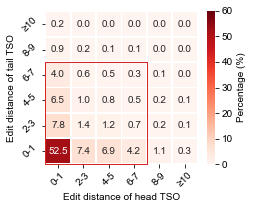

In [3]:
plt.figure(figsize=(3.6, 3))
sns.heatmap(m, annot=True, fmt=".1f", cmap="Reds", lw=0.5, vmin=0, vmax=60,
            square=True, cbar_kws={"label": "Percentage (%)"})
if True:
    plt.plot([0, 4], [2, 2], color="C3", lw=1, clip_on=False)
    plt.plot([0, 4], [6, 6], color="C3", lw=1, clip_on=False)
    plt.plot([0, 0], [2, 6], color="C3", lw=1, clip_on=False)
    plt.plot([4, 4], [2, 6], color="C3", lw=1, clip_on=False)
plt.xlabel("Edit distance of head TSO")
plt.ylabel("Edit distance of tail TSO")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.savefig("figures/dual_tso_ed_distribution.pdf", dpi=300)

# Profiling of polyA

In [3]:
array = []
for run in runs:
    tmp = infos[infos["Run"] == run]
    m = np.zeros((6, 6), dtype=np.int)
    for cell in tmp["Cell"]:
        path = "../../1_NanoNASCseq/results/demux/trimmed/%s/%s/polya.tsv" % (run, cell)
        with open(path) as f:
            for i, line in enumerate(f):
                if i > 0:
                    row = line.strip("\n").split("\t")
                    n1, n2, count = row[:3]
                    n1 = int(n1)
                    n2 = int(n2)
                    n1 = min(n1, 25)
                    n2 = min(n2, 25)
                    m[int(n1/5)][int(n2/5)] += int(count)
    m = pd.DataFrame(m)
    m = m * 100 / m.sum().sum()
    m.columns = ["0-4", "5-9", "10-14", "15-19", "20-24", "≥25"]
    m.index = m.columns
    array.append(m)
m = sum(array) / len(array)
m = m[::-1]

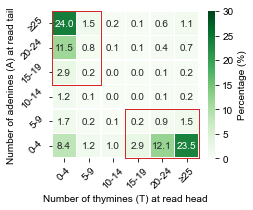

In [5]:
plt.figure(figsize=(3.6, 3))
sns.heatmap(m, annot=True, fmt=".1f", cmap="Greens", lw=0.5, vmin=0, vmax=30,
            square=True, cbar_kws={"label": "Percentage (%)"})
if True:
    plt.plot([0, 2], [0, 0], color="C3", lw=1, clip_on=False)
    plt.plot([0, 2], [3, 3], color="C3", lw=1, clip_on=False)
    plt.plot([0, 0], [0, 3], color="C3", lw=1, clip_on=False)
    plt.plot([2, 2], [0, 3], color="C3", lw=1, clip_on=False)
    
    plt.plot([3, 6], [4, 4], color="C3", lw=1, clip_on=False)
    plt.plot([3, 6], [6, 6], color="C3", lw=1, clip_on=False)
    plt.plot([3, 3], [4, 6], color="C3", lw=1, clip_on=False)
    plt.plot([6, 6], [4, 6], color="C3", lw=1, clip_on=False)
    
plt.xlabel("Number of thymines (T) at read head")
plt.ylabel("Number of adenines (A) at read tail")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.savefig("figures/polya_length_distribution.pdf", dpi=300)

# PolyA length

In [6]:
max_len = 40
rows = []
for run in runs:
    tmp = infos[infos["Run"] == run]
    counts = np.zeros(max_len + 1, dtype=np.int)
    for cell in tmp["Cell"]:
        path = "../../1_NanoNASCseq/results/demux/trimmed/%s/%s/polya.tsv" % (run, cell)
        with open(path) as f:
            for i, line in enumerate(f):
                if i > 0:
                    row = line.strip("\n").split("\t")
                    n1, n2, count = row[:3]
                    n1 = int(n1)
                    n2 = int(n2)
                    n = max(n1, n2)
                    n = min(n, len(counts) - 1)
                    counts[n] += int(count)
    rows.append(counts)

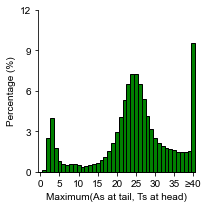

In [7]:
m = pd.DataFrame(rows)
m = m.divide(m.sum(axis=1), axis=0) * 100
ys = m.mean(axis=0)
yerr = m.std(axis=0)
xs = np.arange(len(ys))
colors = ["green"] * len(xs)
# for x in range(15):
#     colors[x] = "none"
    
plt.figure(figsize=(3, 3))
plt.bar(xs, ys, yerr=yerr, color=colors, edgecolor="black", 
        lw=1, width=1, error_kw={"capsize": 0, "lw": 0}, clip_on=False)
plt.xlim(min(xs) - 0.5, max(xs) + 0.5)
plt.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40], ["0", "5", "10", "15", "20", "25", "30", "35", "≥40"])
plt.ylim(0, 12)
plt.yticks(np.arange(0, 13, 3))
# plt.text(2, 15 * 0.9, "MAX(As, Ts) ≥ 15 (%.1f%%)" % sum(ys[15:]))
plt.xlabel("Maximum(As at tail, Ts at head)")
plt.ylabel("Percentage (%)")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.tight_layout()
plt.savefig("figures/polya_length_distribution.bar.pdf", dpi=300)

# Edit distance of anchor

In [8]:
max_ed = 5

rows = []
for run in runs:
    counter = defaultdict(int)
    for cell in infos[infos["Run"] == run]["Cell"]:
        path = "../../1_NanoNASCseq/results/demux/trimmed/%s/%s/anchor.tsv" % (run, cell)
        with open(path) as f:
            for i, line in enumerate(f):
                if i > 0:
                    row = line.strip("\n").split("\t")
                    x, ed, count = row[:3]
                    if int(x) <= 2:
                        counter[int(ed)] += int(count)
    row = [counter[ed] for ed in range(0, max_ed)]
    row.append(sum(counter.values()) - sum(row))
    rows.append(row)
d = pd.DataFrame(rows)
d = d.divide(d.sum(axis=1), axis=0) * 100
vs = d[[0, 1, 2]].sum(axis=1)
mean, std = np.mean(vs), np.std(vs)
print(mean, std)

98.50686728431413 0.24438283813505818


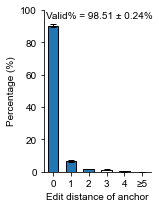

In [9]:
ys = d.mean(axis=0)

yerr = d.std(axis=0)
xs = np.arange(len(ys))
ticks = [str(ed) for ed in range(max_ed + 1)]
ticks[-1] = "≥%s" % ticks[-1]
colors = ["none"] * len(ys)
colors[0] = "C0"
colors[1] = "C0"
colors[2] = "C0"

plt.figure(figsize=(2.3, 3))
plt.bar(xs, ys, yerr=yerr, width=0.6, color=colors, edgecolor="black", error_kw={"capsize": 3, "lw": 1})
plt.text(-0.4, 100 * 0.95, "Valid%% = %.2f ± %.2f%%" % (mean, std))
plt.xlim(-0.5, 5.5)
plt.ylim(0, 100)
plt.xticks(xs, ticks)
plt.xlabel("Edit distance of anchor")
plt.ylabel("Percentage (%)")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.tight_layout()
plt.savefig("figures/anchor_ed.pdf", dpi=300)

# Profiling of UMI length

In [11]:
rows = []
min_len = 8
max_len = 16
for run in runs:
    counts = np.zeros(max_len - min_len + 1)
    for path in sorted(glob.glob("../../1_NanoNASCseq/results/demux/trimmed/%s/*/umi.tsv" % run)):
        with open(path) as f:
            for i, line in enumerate(f):
                if i > 0:
                    row = line.strip("\n").split("\t")
                    v = int(row[0])
                    count = int(row[1])
                    v = max(v, min_len)
                    v = min(v, max_len)
                    counts[v - min_len] += count
    rows.append(counts)
m = pd.DataFrame(rows, index=runs)
m = m.divide(m.sum(axis=1), axis=0) * 100
vs = m[[3, 4, 5]].sum(axis=1)
mean, std = np.mean(vs), np.std(vs)
print(mean, std)

90.21237798350815 0.9678959216859628


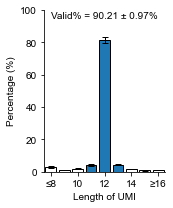

In [12]:
ys = m.mean(axis=0)
yerr = m.std(axis=0)
xs = np.arange(len(ys)) + min_len
colors = ["none", "none", "none", "C0", "C0", "C0", "none", "none", "none"]
plt.figure(figsize=(2.5, 3))
plt.bar(xs, ys, yerr=yerr, color=colors, width=0.8, edgecolor="black", error_kw={"capsize": 3, "lw": 1})
plt.text(8, 100 * 0.95, "Valid%% = %.2f ± %.2f%%" % (mean, std))
plt.xlim(min(xs) - 0.5, max(xs) + 0.5)
plt.ylim(0, 100)

xs1 = np.arange(min_len, max_len + 1, 2)
ticks = [str(x) for x in xs1]
ticks[0] = "≤%s" % ticks[0]
ticks[-1] = "≥%s" % ticks[-1]
plt.xticks(xs1, ticks)

plt.xlabel("Length of UMI")
plt.ylabel("Percentage (%)")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.tight_layout()
plt.savefig("figures/umi_length_distribution.pdf", dpi=300)

# Summary of trimming

In [13]:
array = []
for run in runs:
    for cell in infos[infos["Run"] == run]["Cell"]:
        path = "../../1_NanoNASCseq/results/demux/trimmed/%s/%s/stats.tsv" % (run, cell)
        d = pd.read_csv(path, sep="\t", index_col=0)
        array.append(d)
d = pd.concat(array)
d["TooShort"] = d["RawTooShort"] + d["TrimTooShort"]

In [14]:
cs = ["Total", "NoTSO", "IsChimeric", "NoDirection", "NoAnchor", "NoUMI", "TooShort", "Pass"]
array = []
for c in cs:
    s = d[c] / d["Total"]
    s.name = c
    array.append(s)
m = pd.concat(array, axis=1)
print("Cells:", len(m))

Cells: 440


Total          1.000000
NoTSO          0.019240
IsChimeric     0.013523
NoDirection    0.177474
NoAnchor       0.019399
NoUMI          0.076072
TooShort       0.000157
Pass           0.694136
dtype: float64


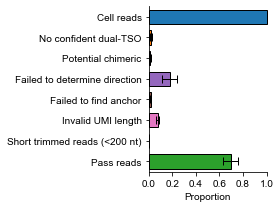

In [15]:
ticks = ["Cell reads", 
         "No confident dual-TSO", 
         "Potential chimeric", 
         "Failed to determine direction", 
         "Failed to find anchor", 
         "Invalid UMI length",
         "Short trimmed reads (<200 nt)",
         "Pass reads"]
colors = ["C0", "C1", "C3", "C4", "C5", "C6", "C7", "C2"]
means = m.mean(axis=0)
stds = m.std(axis=0)
xs = np.arange(len(means))[::-1]

plt.figure(figsize=(4, 3))
plt.barh(xs, means, xerr=stds, edgecolor="black", height=0.7, clip_on=False,
         error_kw={"capsize": 4, "lw": 1}, color=colors)
print(means)
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.yticks(xs, ticks, rotation=0)
plt.ylim(min(xs) - 0.5, max(xs) + 0.5)
plt.xlim(0, 1)
plt.xlabel("Proportion")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.tight_layout()
plt.savefig("figures/strict_trim_porportion.pdf", dpi=300)

# Summary of cell reads

20220719_K562R1
20220719_K562R2
20220719_K562R3
20220719_K562R4
20220729_K562R1
20220729_K562R2


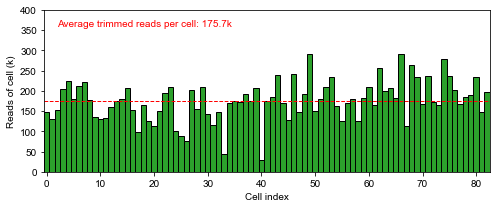

In [16]:
for run in runs:
    print(run)
    if run != "20220719_K562R1":
        continue
    ys = []
    for cell in infos[infos["Run"] == run]["Cell"]:
        p = "../../1_NanoNASCseq/results/demux/trimmed/%s/%s/stats.tsv" % (run, cell)
        d = pd.read_csv(p, sep="\t", index_col=0)
        y = d["Pass"].values[0]
        ys.append(y)
    ys = np.array(ys) / 1e3
    xs = np.arange(len(ys))
    plt.figure(figsize=(7, 3))
    plt.bar(xs, ys, width=1, color="C2", edgecolor="black", lw=1)
    plt.axhline(np.mean(ys), lw=1, ls="--", color="red")
    ylim = (int(max(ys) / 100) + 2) * 100
    plt.text(2, ylim * 0.9, "Average trimmed reads per cell: %.1fk" % np.mean(ys), color="red")
    plt.xlim(min(xs) - 0.5, max(xs) + 0.5)
    plt.ylim(0, ylim)
    plt.xlabel("Cell index")
    plt.ylabel("Reads of cell (k)")
    plt.tight_layout()
    if False:
        plt.show()
        plt.close()
    else:
        plt.savefig("figures/average_reads_per_cell.pdf", dpi=300)